<a href="https://colab.research.google.com/github/vicentbas/ia3_uv/blob/main/ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---
# Trabajo evaluación bloque 2: Clasificador de electrocardiogramas mediante LSTM

#<strong><center> ECG analyzer </strong></center>

El objetivo del siguiente proyecto es crear un clasificador de electrocardiogramas, capaz de diferencias entre estudios patológicos y estudios normales. Como entrada al proyecto se utilzan ficheros XML exportados desde el sistema Philips IntelliSpace ECG B.00.02 en formato XML FDA para electrocardiografos de 12 derivaciones.

In [1]:
from xml.dom import minidom
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Input, Concatenate, GlobalMaxPooling1D, BatchNormalization, Activation
from keras.optimizers import Adam
from tensorflow import keras

import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [55]:
column_names = [
  'lead',
  'mV',
  'severity'
]
ecg = pd.DataFrame(columns=column_names)

mV   = []
lead = []
severity  = []

In [122]:
def extract_data(file):
  data = pd.DataFrame({'lead':[],'mV':[], 'severity':[]})
  mV   = []
  severity = []
  ecg_xml_diag = minidom.parse(file.split(".")[0]+"."+file.split(".")[3]) 
  ecg_xml_severity = ecg_xml_diag.getElementsByTagName('severity')
  ecg_severity = ecg_xml_severity[0].firstChild.data
  ecg_xml = minidom.parse(file) 
  ecg_leads_mvs = ecg_xml.getElementsByTagName('digits')
  for idx, ecg_leads_mv in enumerate(ecg_leads_mvs):
    if idx < 12:
      ecg_leads_mv = ecg_leads_mv.firstChild.data
      ecg_leads_mv = ecg_leads_mv.replace("\n","")
      ecg_leads_mv = ecg_leads_mv.replace("\t","")
      ecg_leads_mv = ecg_leads_mv.replace("  ","")
      ecg_leads_mv = ecg_leads_mv.replace("  ","")
      ecg_leads_mv = ecg_leads_mv.split(" ")[:-1]
      if ecg_severity == '1':
        severity = np.ones(5500)
      if ecg_severity == '0':
        severity = np.zeros(5500)
      lead = np.ones(5500) * idx
      data = data.append(pd.DataFrame({'lead':lead,'mV':ecg_leads_mv, 'severity':severity}))
  return data

In [125]:
#mV = extract_data('/content/ecg/00dc9180-9da7-11da-4823-0b97bffb0029.aECG.fda.xml')
ecg_studies = pd.DataFrame({'lead':[],'mV':[], 'severity':[]})
for file in listdir('/content/ecg/'):
  if "fda" in file:
    data = extract_data('/content/ecg/'+file)
    ecg_studies = ecg_studies.append(data, ignore_index=True)

In [128]:
#print(ecg_studies)
#ecg_studies.to_csv('out.csv', index=False) 

         lead  mV  severity
0         0.0   0       1.0
1         0.0   0       1.0
2         0.0  -1       1.0
3         0.0   0       1.0
4         0.0   0       1.0
...       ...  ..       ...
5411995  11.0   0       1.0
5411996  11.0   0       1.0
5411997  11.0   0       1.0
5411998  11.0   0       1.0
5411999  11.0   0       1.0

[5412000 rows x 3 columns]


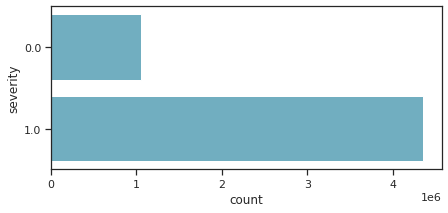

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="severity", data=ecg_studies, color="c")

In [83]:
def extract_data(file):
  ecg_xml_diag = minidom.parse(file.split(".")[0]+"."+file.split(".")[3]) 
  ecg_xml_severity = ecg_xml_diag.getElementsByTagName('severity')
  ecg_severity = ecg_xml_severity[0].firstChild.data
  ecg_xml = minidom.parse(file) 
  ecg_leads_beats = ecg_xml.getElementsByTagName('digits')
  ecg_leads = pd.DataFrame({'lead':[]})
  for idx, ecg_lead_beat in enumerate(ecg_leads_beats):
    ecg_lead_beat = ecg_lead_beat.firstChild.data
    ecg_lead_beat = ecg_lead_beat.replace("\n","")
    ecg_lead_beat = ecg_lead_beat.replace("\t","")
    ecg_lead_beat = ecg_lead_beat.replace("  ","")
    ecg_lead_beat = ecg_lead_beat.split(" ")[:-1]
    ecg_lead_beat = np.array(ecg_lead_beat,dtype=float)
    if idx < 12:
      ecg_leads = ecg_leads.append(pd.DataFrame({'lead':[ecg_lead_beat], 'diagnoses':[ecg_severity]}), ignore_index=True)
  return ecg_leads, ecg_severity

In [85]:
ecg_studies = pd.DataFrame({'studies':[], 'diagnoses':[]})
for file in listdir('/content/ecg/'):
  if "fda" in file:
    ecg_leads, ecg_severity = extract_data('/content/ecg/'+file)
    ecg_studies = ecg_studies.append(pd.DataFrame({'studies':[ecg_leads], 'diagnoses':ecg_severity}), ignore_index=True)

In [137]:
print(ecg_studies['studies'][0])

KeyError: ignored

# Ploting sample leads

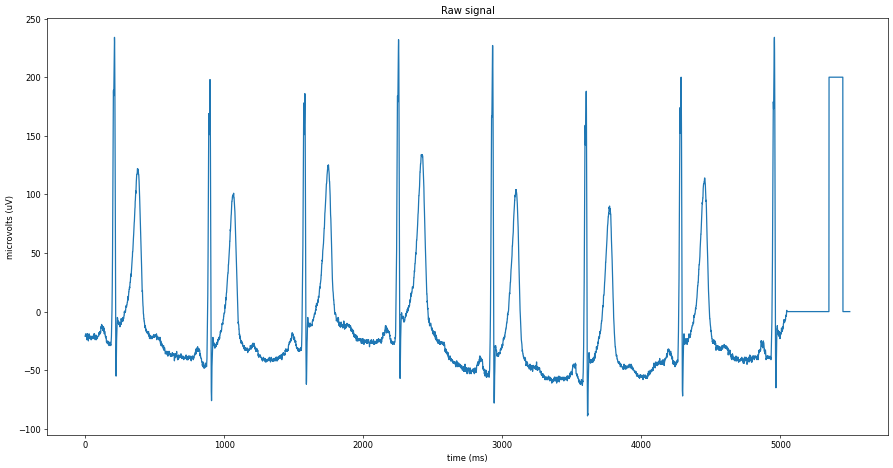

In [4]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_studies['studies'][3]['lead'][9])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

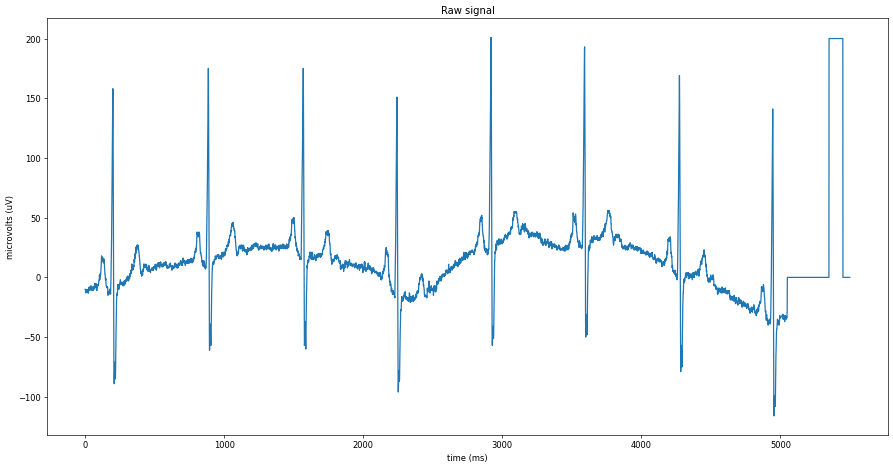

In [5]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_studies['studies'][3]['lead'][1])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

# Understanding data structure
Anidación de dataframes, con un primer nivel para estudios y un segundo nivel para cada una de las derivaciones.

**Diagnostico:**

0 = estudio normal

1 = estudio fuera de lo normal

In [6]:
print(ecg_studies)

                                              studies diagnoses
0                                                 ...         1
1                                                 ...         1
2                                                 ...         1
3                                                 ...         1
4                                                 ...         1
..                                                ...       ...
77                                                ...         1
78                                                ...         1
79                                                ...         0
80                                                ...         0
81                                                ...         1

[82 rows x 2 columns]


In [7]:
from collections import Counter
print(Counter(ecg_studies['diagnoses']))

Counter({'1': 66, '0': 16})


In [8]:
print(ecg_studies['studies'][0])

                                                 lead serverity
0   [0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0,...         1
1   [47.0, 47.0, 47.0, 47.0, 48.0, 47.0, 47.0, 45....         1
2   [47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 45.0, 46....         1
3   [-24.0, -23.0, -23.0, -23.0, -24.0, -23.0, -24...         1
4   [-24.0, -23.0, -24.0, -24.0, -24.0, -24.0, -23...         1
5   [47.0, 47.0, 47.0, 47.0, 48.0, 47.0, 46.0, 44....         1
6   [67.0, 67.0, 67.0, 66.0, 68.0, 68.0, 69.0, 70....         1
7   [-115.0, -113.0, -114.0, -113.0, -114.0, -113....         1
8   [-121.0, -120.0, -121.0, -121.0, -121.0, -120....         1
9   [-112.0, -111.0, -112.0, -113.0, -112.0, -111....         1
10  [-119.0, -118.0, -119.0, -121.0, -122.0, -122....         1
11  [-109.0, -107.0, -109.0, -110.0, -111.0, -112....         1


# Data normalization

In [9]:
for idxe, ecg in ecg_studies.iterrows():
  for idxs, study in ecg['studies'].iterrows():
    for lead in study:
      x = ecg_studies['studies'][idxe]['lead'][idxs].reshape(-1, 1)
      min_max_scaler = preprocessing.MinMaxScaler()
      x_scaled = min_max_scaler.fit_transform(x)
      ecg_studies['studies'][idxe]['lead'][idxs] = x_scaled

In [10]:
print(ecg_studies['studies'][0])

                                                 lead serverity
0   [[0.20948616600790512], [0.20948616600790512],...         1
1   [[0.27651515151515155], [0.27651515151515155],...         1
2   [[0.26168224299065423], [0.26168224299065423],...         1
3   [[0.5684007707129095], [0.5703275529865126], [...         1
4   [[0.5437881873727087], [0.5458248472505092], [...         1
5   [[0.2682291666666667], [0.2682291666666667], [...         1
6   [[0.7518656716417911], [0.7518656716417911], [...         1
7   [[0.48697068403908805], [0.49022801302931607],...         1
8   [[0.4685430463576159], [0.4701986754966887], [...         1
9   [[0.3577075098814229], [0.3596837944664032], [...         1
10  [[0.16063675832127355], [0.1620839363241679], ...         1
11  [[0.1576923076923077], [0.16025641025641024], ...         1


In [11]:
print(ecg_studies['studies'][1])

                                                 lead serverity
0   [[0.1947565543071161], [0.20599250936329588], ...         1
1   [[0.2557251908396947], [0.2442748091603054], [...         1
2   [[0.41379310344827586], [0.3949843260188088], ...         1
3   [[0.46341463414634143], [0.46341463414634143],...         1
4   [[0.2482014388489209], [0.25899280575539574], ...         1
5   [[0.22891566265060243], [0.21285140562249], [0...         1
6   [[0.5523114355231143], [0.5547445255474452], [...         1
7   [[0.6762075134168157], [0.6762075134168157], [...         1
8   [[0.5613207547169812], [0.5636792452830188], [...         1
9   [[0.39365079365079364], [0.39365079365079364],...         1
10  [[0.2274509803921569], [0.2235294117647059], [...         1
11  [[0.19918699186991873], [0.1951219512195122], ...         1


In [12]:
print(ecg_studies)

                                              studies diagnoses
0                                                 ...         1
1                                                 ...         1
2                                                 ...         1
3                                                 ...         1
4                                                 ...         1
..                                                ...       ...
77                                                ...         1
78                                                ...         1
79                                                ...         0
80                                                ...         0
81                                                ...         1

[82 rows x 2 columns]


# RNN LSTM building

In [15]:
def f1(normalize=False, epsilon=1e-16, beta=1):
  def f_loss(y_true, y_pred):
    if normalize:
      y_pred = max_min(y_pred)
    tp = K.sum(y_true * y_pred, axis=0)[1]
    fp = K.sum((1. - y_true) * y_pred, axis=0)[1]
    fn = K.sum(y_true * (1. - y_pred), axis=0)[1]
    pr = (tp / (tp + fp + epsilon) + epsilon)
    rc = (tp / (tp + fn + epsilon) + epsilon)
    f1 = ((1. + (beta**2)) * pr * rc) / ((beta**2) * pr + rc)
    loss = -K.sum(y_true * f1, axis=1)
    return loss
  return f_loss

lead_1_inp = Input(ecg_studies['studies'][0]['lead'][0].shape)
lead_1_LSTM = LSTM(8, return_sequences=True)(lead_1_inp)
lead_1_LSTM = GlobalMaxPooling1D()(lead_1_LSTM)

lead_2_inp = Input(ecg_studies['studies'][1]['lead'][1].shape)
lead_2_LSTM = LSTM(8, return_sequences=True)(lead_2_inp)
lead_2_LSTM = GlobalMaxPooling1D()(lead_2_LSTM)

lead_3_inp = Input(ecg_studies['studies'][2]['lead'][2].shape)
lead_3_LSTM = LSTM(8, return_sequences=True)(lead_3_inp)
lead_3_LSTM = GlobalMaxPooling1D()(lead_3_LSTM)

lead_4_inp = Input(ecg_studies['studies'][3]['lead'][3].shape)
lead_4_LSTM = LSTM(8, return_sequences=True)(lead_4_inp)
lead_4_LSTM = GlobalMaxPooling1D()(lead_4_LSTM)

lead_5_inp = Input(ecg_studies['studies'][4]['lead'][4].shape)
lead_5_LSTM = LSTM(8, return_sequences=True)(lead_5_inp)
lead_5_LSTM = GlobalMaxPooling1D()(lead_5_LSTM)

lead_6_inp = Input(ecg_studies['studies'][5]['lead'][5].shape)
lead_6_LSTM = LSTM(8, return_sequences=True)(lead_6_inp)
lead_6_LSTM = GlobalMaxPooling1D()(lead_6_LSTM)

lead_7_inp = Input(ecg_studies['studies'][6]['lead'][6].shape)
lead_7_LSTM = LSTM(8, return_sequences=True)(lead_7_inp)
lead_7_LSTM = GlobalMaxPooling1D()(lead_7_LSTM)

lead_8_inp = Input(ecg_studies['studies'][7]['lead'][7].shape)
lead_8_LSTM = LSTM(8, return_sequences=True)(lead_8_inp)
lead_8_LSTM = GlobalMaxPooling1D()(lead_8_LSTM)

lead_9_inp = Input(ecg_studies['studies'][8]['lead'][8].shape)
lead_9_LSTM = LSTM(8, return_sequences=True)(lead_9_inp)
lead_9_LSTM = GlobalMaxPooling1D()(lead_9_LSTM)

lead_10_inp = Input(ecg_studies['studies'][9]['lead'][9].shape)
lead_10_LSTM = LSTM(8, return_sequences=True)(lead_10_inp)
lead_10_LSTM = GlobalMaxPooling1D()(lead_10_LSTM)

lead_11_inp = Input(ecg_studies['studies'][10]['lead'][10].shape)
lead_11_LSTM = LSTM(8, return_sequences=True)(lead_11_inp)
lead_11_LSTM = GlobalMaxPooling1D()(lead_11_LSTM)

lead_12_inp = Input(ecg_studies['studies'][11]['lead'][11].shape)
lead_12_LSTM = LSTM(8, return_sequences=True)(lead_12_inp)
lead_12_LSTM = GlobalMaxPooling1D()(lead_12_LSTM)

In [16]:
concat = Concatenate()([lead_1_LSTM, lead_2_LSTM, lead_3_LSTM, lead_4_LSTM, lead_5_LSTM, lead_6_LSTM,
                             lead_7_LSTM, lead_8_LSTM, lead_9_LSTM, lead_10_LSTM, lead_11_LSTM, lead_12_LSTM])
# FC layer para "fusionar" las representaciones.
h_1 = Dense(8)(concat)
h_1 = BatchNormalization()(h_1)
h_1 = Activation("tanh")(h_1)

# Softmax FC layer para calcular p(y|x) : y \in {0, 1}
o = Dense(2, activation="softmax")(h_1)

# El modelo toma como entradas el vector de información de usuario y las 3 secuencias de 
# model = Model(inputs = [inp_pay, inp_bill_amt, inp_pay_amt, inp_user_info], outputs = o)
model = Model(inputs = [lead_1_inp, lead_2_inp, lead_3_inp, lead_4_inp, lead_5_inp, lead_6_inp
                        , lead_7_inp, lead_8_inp, lead_9_inp, lead_10_inp, lead_11_inp, lead_12_inp], outputs = o)
model.compile(optimizer="adam", loss=f1(), metrics=["accuracy"])

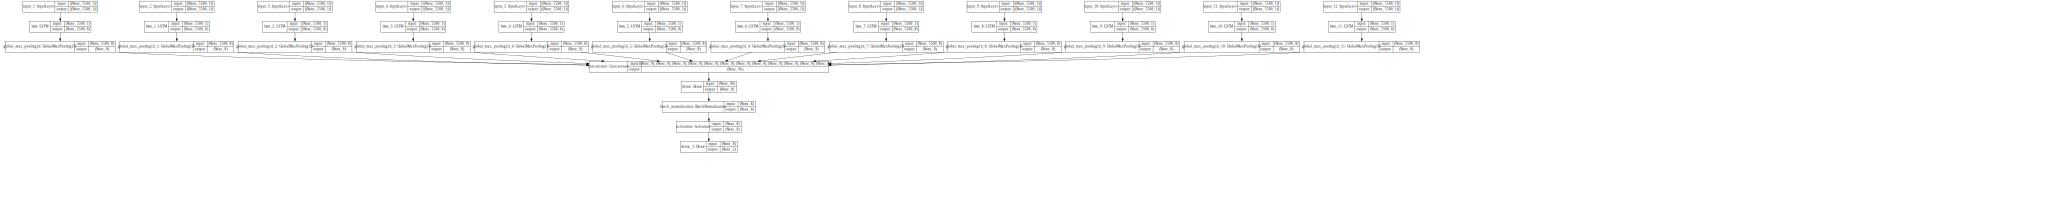

In [17]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

display(SVG(model_to_dot(model, show_shapes=True, dpi=50).create(prog='dot', format='svg')))